# Multi-Degree Drug Interaction Kinetics Test

**Purpose**: Test kinetic behavior of multi-degree drug interaction network using DegreeInteractionSpec

**System**: D → {R1_i} → {I1_i} → O central pathway with higher-degree cascades providing feedback

**Degrees**: [1, 2, 4] where:
  - Degree 1: 1 cascade (R1_1 → I1_1 → O) - central pathway
  - Degree 2: 2 cascades (R2_1 → I2_1, R2_2 → I2_2) - feedback to degree 1
  - Degree 3: 4 cascades (R3_1 → I3_1, ..., R3_4 → I3_4) - feedback to degree 2

**Feedback Regulation Algorithm**:
  - **Mandatory downward regulations**: Each I species in degree n>1 regulates random R/I species in degree n-1
  - **Density-controlled upward regulations**: feedback_density controls proportion of cascades with upward feedback
  - **Adjacent degrees only**: All feedback connects only between degrees n and n-1
  - **Trimming**: When density < 1, upward regulations trimmed from outermost degrees first

**Focus**: Test functionality of multi-degree network, feedback regulations, and drug response

## Initial Setup

Simple path configuration for proper module imports

In [10]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


## Imports

Minimal imports focusing on DegreeInteractionSpec

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from models.Specs.DegreeInteractionSpec import DegreeInteractionSpec
from models.Specs.Drug import Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

print("Imports complete")

Imports complete


## 1. Create Multi-Degree Network

Create the network with degree_cascades=[1, 2, 4]
This creates a total of 1+2+4 = 7 cascades × 2 species each + O = 15 species

In [12]:
# Initialize degree interaction specification
degree_spec = DegreeInteractionSpec(degree_cascades=[1, 2, 4])

# Generate complete specifications with moderate feedback density
degree_spec.generate_specifications(
    random_seed=42,
    feedback_density=0.3  # 30% of cascades get upward feedback (mandatory downward always present)
)

print(f"Network created with {len(degree_spec.species_list)} species")
print(f"Degrees: {list(degree_spec.degree_species.keys())}")

# Show species by degree
for degree in [1, 2, 3]:
    species = degree_spec.get_species_by_degree(degree, 'all')
    print(f"Degree {degree} species ({len(species)}): {species[:4]}..." if len(species) > 4 else f"Degree {degree} species: {species}")
    
all_regulations = degree_spec.regulations
print(f"Total regulations: {len(all_regulations)}")

# print regulations one by one 
for reg in all_regulations:
    print(reg)

Network created with 15 species
Degrees: [1, 2, 3]
Degree 1 species: ['R1_1', 'I1_1']
Degree 2 species: ['R2_1', 'R2_2', 'I2_1', 'I2_2']
Degree 3 species (8): ['R3_1', 'R3_2', 'R3_3', 'R3_4']...
Total regulations: 16
Regulation(from_specie='R1_1', to_specie='I1_1', reg_type='up')
Regulation(from_specie='I1_1', to_specie='O', reg_type='up')
Regulation(from_specie='R2_1', to_specie='I2_1', reg_type='up')
Regulation(from_specie='R2_2', to_specie='I2_2', reg_type='up')
Regulation(from_specie='R3_1', to_specie='I3_1', reg_type='up')
Regulation(from_specie='R3_2', to_specie='I3_2', reg_type='up')
Regulation(from_specie='R3_3', to_specie='I3_3', reg_type='up')
Regulation(from_specie='R3_4', to_specie='I3_4', reg_type='up')
Regulation(from_specie='I2_1', to_specie=np.str_('R1_1'), reg_type=np.str_('down'))
Regulation(from_specie='I2_2', to_specie=np.str_('I1_1'), reg_type=np.str_('up'))
Regulation(from_specie='I3_1', to_specie=np.str_('I2_1'), reg_type=np.str_('down'))
Regulation(from_specie='

## 2. Add Drug Targeting Degree 1 R Species

Drug D will target R1_1 (the only degree 1 R species) with down-regulation

In [13]:
# Create drug D that down-regulates R1_1
drug_d = Drug(
    name="D",
    start_time=500.0,     # Drug applied at time 500
    default_value=10.0,    # Drug concentration
    regulation=["R1_1"],  # Regulates R1_1 (degree 1, cascade 1)
    regulation_type=["down"]  # Down-regulation decreases activation
)

# Add drug to model
degree_spec.add_drug(drug_d)
print(f"Drug added: {drug_d.name} targeting {drug_d.regulation}")

# Verify drug validation works
print(f"Drug species list: {[d.name for d in degree_spec.drugs]}")
print(f"Total regulations: {len(degree_spec.regulations)}")

Drug added: D targeting ['R1_1']
Drug species list: ['D']
Total regulations: 17


## 3. Generate Model with Controlled Parameters

Create the actual model with parameter ranges for testing functionality

In [14]:
# Generate the model
model = degree_spec.generate_network(
    network_name="MultiDegree_Kinetics",
    mean_range_species=(50, 150),      # Initial concentrations
    rangeScale_params=(0.8, 1.2),      # ±20% variation
    rangeMultiplier_params=(0.9, 1.1), # Small additional variation
    random_seed=42,
    receptor_basal_activation=True     # Receptors have basal activation
)

print(f"Model created: {model.name}")
print(f"Total reactions: {len(model.reactions)}")
print(f"Total states: {len(model.states)}")
print(f"Total parameters: {len(model.parameters)}")

# Show a few key states
key_states = ['R1_1', 'I1_1', 'R2_1', 'I2_1', 'R3_1', 'I3_1', 'O']
available_states = [s for s in key_states if s in model.states]
print(f"Key states available: {available_states}")

Model created: MultiDegree_Kinetics
Total reactions: 30
Total states: 30
Total parameters: 77
Key states available: ['R1_1', 'I1_1', 'R2_1', 'I2_1', 'R3_1', 'I3_1', 'O']


In [15]:
print(model.get_antimony_model())

model MultiDegree_Kinetics

J0: R1_1a -> R1_1; Vmax_J0*R1_1a/(Km_J0 + R1_1a)
J1: R1_1 -> R1_1a; Kc_J1*R1_1/(Km_J1 + R1_1)/(1 + I2_1a/Ki0_J1 + D/Ki1_J1)
J2: I1_1a -> I1_1; Vmax_J2*I1_1a/(Km_J2 + I1_1a)
J3: I1_1 -> I1_1a; (Kc_J3+Kc0_J3*R1_1a+Kc1_J3*I2_2a)*I1_1/(Km_J3 + I1_1)
J4: R2_1a -> R2_1; Vmax_J4*R2_1a/(Km_J4 + R2_1a)
J5: R2_1 -> R2_1a; Vmax_J5*R2_1/(Km_J5 + R2_1)
J6: I2_1a -> I2_1; Vmax_J6*I2_1a/(Km_J6 + I2_1a)
J7: I2_1 -> I2_1a; (Kc_J7+Kc0_J7*R2_1a+Kc1_J7*I3_4a+Kc2_J7*R1_1a)*I2_1/(Km_J7 + I2_1)/(1 + I3_1a/Ki0_J7 + I3_2a/Ki1_J7 + I3_3a/Ki2_J7)
J8: R2_2a -> R2_2; Vmax_J8*R2_2a/(Km_J8 + R2_2a)
J9: R2_2 -> R2_2a; Vmax_J9*R2_2/(Km_J9 + R2_2)
J10: I2_2a -> I2_2; Vmax_J10*I2_2a/(Km_J10 + I2_2a)
J11: I2_2 -> I2_2a; (Kc_J11+Kc0_J11*R2_2a)*I2_2/(Km_J11 + I2_2)
J12: R3_1a -> R3_1; Vmax_J12*R3_1a/(Km_J12 + R3_1a)
J13: R3_1 -> R3_1a; Vmax_J13*R3_1/(Km_J13 + R3_1)
J14: I3_1a -> I3_1; Vmax_J14*I3_1a/(Km_J14 + I3_1a)
J15: I3_1 -> I3_1a; (Kc_J15+Kc0_J15*R3_1a)*I3_1/(Km_J15 + I3_1)
J16: R3_2a -> R3

## 5. Test Basic Functionality with Simulation

Simulate the multi-degree network to verify it works correctly

In [16]:
# Create solver
solver = RoadrunnerSolver()

# Compile model and simulate
try:
    solver.compile(model.get_sbml_model())
    result = solver.simulate(start=0, stop=1000, step=101)  # 0-1000 with 101 points
    
    print("Simulation successful!")
    print(f"Timepoints: {len(result['time'])}")
    print(f"Columns: {list(result.columns)[:10]}...")
    
except Exception as e:
    print(f"Simulation error: {e}")
    # Fallback: try to get antimony model for debugging
    print("\nDebug: Antimony model (first 20 lines):")
    antimony_model = model.get_antimony_model()
    print("\n".join(antimony_model.split("\n")[:20]))

Simulation successful!
Timepoints: 101
Columns: ['time', 'R1_1a', 'R1_1', 'I2_1a', 'I1_1a', 'I1_1', 'I2_2a', 'R2_1a', 'R2_1', 'I2_1']...


## 6. Visualize Key Species Across Degrees

Plot representative species from each degree to show signal propagation

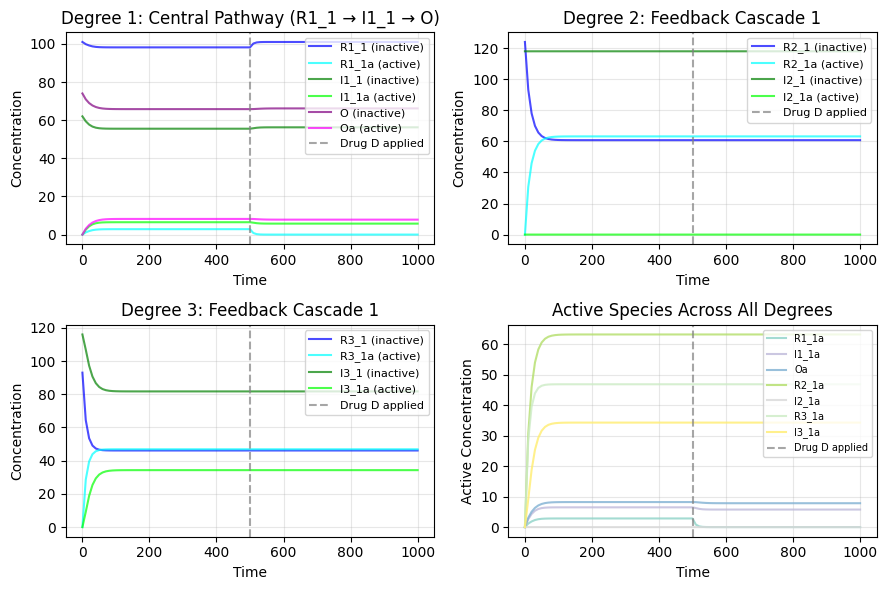

In [17]:
if 'result' in locals():
    plt.figure(figsize=(9, 6))
    
    # Subplot 1: Degree 1 (central pathway)
    plt.subplot(2, 2, 1)
    plt.plot(result['time'], result['R1_1'], label='R1_1 (inactive)', color='blue', alpha=0.7)
    plt.plot(result['time'], result['R1_1a'], label='R1_1a (active)', color='cyan', alpha=0.7)
    plt.plot(result['time'], result['I1_1'], label='I1_1 (inactive)', color='green', alpha=0.7)
    plt.plot(result['time'], result['I1_1a'], label='I1_1a (active)', color='lime', alpha=0.7)
    plt.plot(result['time'], result['O'], label='O (inactive)', color='purple', alpha=0.7)
    plt.plot(result['time'], result['Oa'], label='Oa (active)', color='magenta', alpha=0.7)
    plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Degree 1: Central Pathway (R1_1 → I1_1 → O)')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Degree 2 (feedback to degree 1)
    plt.subplot(2, 2, 2)
    plt.plot(result['time'], result['R2_1'], label='R2_1 (inactive)', color='blue', alpha=0.7)
    plt.plot(result['time'], result['R2_1a'], label='R2_1a (active)', color='cyan', alpha=0.7)
    plt.plot(result['time'], result['I2_1'], label='I2_1 (inactive)', color='green', alpha=0.7)
    plt.plot(result['time'], result['I2_1a'], label='I2_1a (active)', color='lime', alpha=0.7)
    plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Degree 2: Feedback Cascade 1')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Degree 3 (feedback to degree 2)
    plt.subplot(2, 2, 3)
    plt.plot(result['time'], result['R3_1'], label='R3_1 (inactive)', color='blue', alpha=0.7)
    plt.plot(result['time'], result['R3_1a'], label='R3_1a (active)', color='cyan', alpha=0.7)
    plt.plot(result['time'], result['I3_1'], label='I3_1 (inactive)', color='green', alpha=0.7)
    plt.plot(result['time'], result['I3_1a'], label='I3_1a (active)', color='lime', alpha=0.7)
    plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Degree 3: Feedback Cascade 1')
    plt.legend(loc='upper right', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Drug effect summary
    plt.subplot(2, 2, 4)
    active_species = ['R1_1a', 'I1_1a', 'Oa', 'R2_1a', 'I2_1a', 'R3_1a', 'I3_1a']
    colors = plt.cm.Set3(np.linspace(0, 1, len(active_species)))
    
    for i, species in enumerate(active_species):
        if species in result.columns:
            plt.plot(result['time'], result[species], label=species, color=colors[i], alpha=0.8)
    
    plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
    plt.xlabel('Time')
    plt.ylabel('Active Concentration')
    plt.title('Active Species Across All Degrees')
    plt.legend(loc='upper right', fontsize=7)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()